## 1) Import libraries

In [1]:
!pip install segmentation_models_pytorch --quiet

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.init as initer

import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 2) Dataset

### 2.2) Custom Dataset

In [4]:
VOC_CLASSES = [
    "background",
    "cat_body",
    "cat_ears",
    "cat_eyes",
    "cat_face",
    "cat_feets",
    "cat_muzzle",
    "cat_tail",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [42,125,209],
    [184,61,245],
    [61,245,61],
    [250,250,55],
    [250,50,183],
    [255,96,55],
    [245,147,49],
]

class VOCDataset(Dataset):
    def __init__(self, root="/kaggle/input/catpart-segvoc/catpart_segVOC_01/train_val",
                 is_train=True, transform=None, classes=None):
        # Choose the file for training or validation images
        if is_train:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "train.txt")
        else:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "val.txt")
        
        # Get image names into list
        img_names = []
        with open(img_root, 'r') as rf:
            names = [name.replace('\n','') for name in rf.readlines()]
            for name in names:
                img_names.append(name)
            
        self.classes =  classes
        self.transform = transform
        self.img_names = img_names
        self.root = root
        
    def __len__(self):
        return len(self.img_names)
    
    def _convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # Initialize an empty mask with a channel for each class
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)))
        
        # Create a mask for each class label
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        
        return segmentation_mask

    
    def __getitem__(self, item):
        img_name = self.img_names[item]
        # Load the image and corresponding mask
        img = cv2.imread(os.path.join(self.root, "JPEGImages", img_name + ".jpg"))
        mask = cv2.imread(os.path.join(self.root, "SegmentationClass", img_name + ".png"))
        
        # Convert BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert RGB mask to segmentation mask
       
        mask = self._convert_to_segmentation_mask(mask).astype(np.uint8)

        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.argmax(dim=2).squeeze()  
        
        return img, mask

### 2.1) Test Dataset

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
trainsform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(),
])

VOC_dataset = VOCDataset(is_train= True, transform = trainsform)

Img: torch.Size([3, 224, 224])
Mask: torch.Size([224, 224])
Max Value Img: tensor(2.6400)
Max Value Mask: tensor(7)


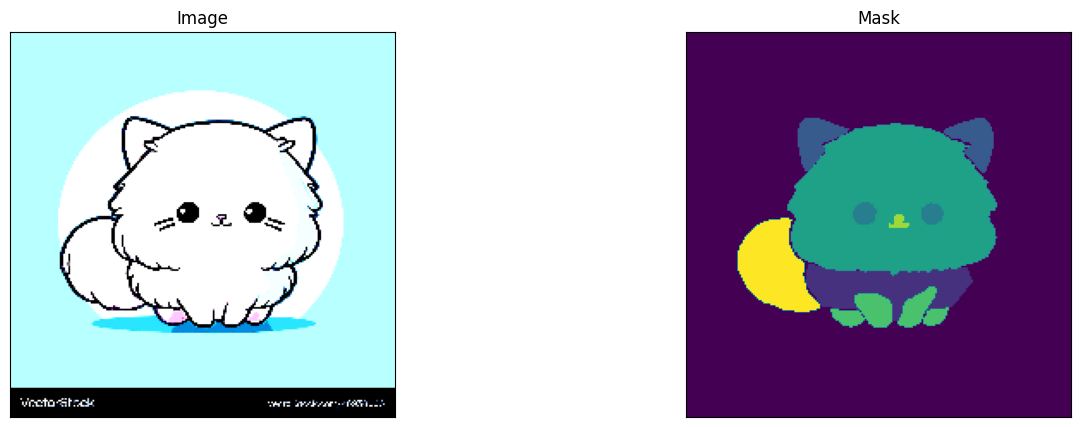

In [7]:
idx = np.random.randint(1,100)
img, mask = VOC_dataset[idx]
print("Img:", img.shape)
print("Mask:", mask.shape)
print("Max Value Img:",img.max())
print("Max Value Mask:",mask.max())

visualize(
    image=img.permute(1,2,0), 
    mask=mask.squeeze(),
)

## 3) Custom Metrics

In [8]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def step_learning_rate(base_lr, epoch, step_epoch, multiplier=0.1):
    """Sets the learning rate to the base LR decayed by 10 every step epochs"""
    lr = base_lr * (multiplier ** (epoch // step_epoch))
    return lr

## 4) Traning Model

### 4.1) Transform 

In [9]:
# transform_size = 257
#Define trainform to images
def img_transform(trainsize= 256):
    train_transform = A.Compose([
    A.Rotate([-10,10]),
    A.RandomScale([0.5,2]),
    A.GaussianBlur(),
    A.HorizontalFlip(),
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Resize(width=trainsize, height=trainsize),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        ToTensorV2(), 
    ])
    return train_transform, test_transform

### 4.2) EarlyStopping

In [10]:
import copy

#patience, min_delta, restore_best_weights, best_model, best_loss counter status
#copy.deepcopy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss > self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stop on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False


### 4.3) Traning fuction and Eval Fuction

In [11]:
# Training fuction
def train(model,train_dataloader,device,optimizer, epoch, EPOCHS, writer, train_loss_meter, criterion):
    model.train()
    train_progress= tqdm(train_dataloader, colour="cyan")
    
    for idx, img_mask in enumerate(train_progress):
        img = img_mask[0].float().to(device) #img - B,C,H,W
        mask = img_mask[1].long().to(device) #label - B,H,W
        y_pred = model(img) #B, 21, H, W
        
        #Optimizer 
        optimizer.zero_grad()
        
        loss = criterion(y_pred, mask) 
        loss.backward()
        optimizer.step()
        
        train_loss_meter.update(loss.item())
        
        # tracking the loss function
        writer.add_scalar("Train/Loss", train_loss_meter.avg, epoch*len(train_dataloader)+idx)
        
        train_progress.set_description("TRAIN| Epoch: {}/{}| Iter: {}/{} | Loss: {:0.4f} | lr: {}".format(
            epoch+1, EPOCHS, idx, len(train_dataloader), loss, optimizer.param_groups[0]['lr']))
        

In [12]:
#Evaluate function
def evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter):
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    
    model.eval()
    with torch.no_grad():
        for idx, img_mask in enumerate(val_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].long().to(device) #B W H

            y_pred = model(img) #B, 21, H, W
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            y_pred = y_pred.argmax(dim=1).squeeze(dim=1)
            
            intersection, union, target = intersectionAndUnionGPU(y_pred.float(), mask.float(), num_classes)
            intersection, union, target = intersection.cpu().numpy(), union.cpu().numpy(), target.cpu().numpy()
            intersection_meter.update(intersection), union_meter.update(union), target_meter.update(target)
            
            if idx>40: break
            
        #compute acc, iou, dice
        accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D
        macc = np.mean(accuracy_class)
        miou = np.mean(iou_class) #mean vector 21D
        mdice = np.mean(dice_class) #mean vector 21D
        
    return macc, miou, mdice

### 4.4) Traning Deeplabv3 ++ Model

In [13]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.nn import BCELoss

from collections import OrderedDict
import segmentation_models_pytorch as smp
import shutil
from tqdm import tqdm

def main(learning_rate, batch_size, epochs, num_workers, data_path, model_save_path, tensorboard_path, num_classes, checkpoint_path):
    
    # Create model save directory if it doesn't exist
    if not os.path.isdir(model_save_path):
        os.mkdir(model_save_path)
    # Creater tensorboard directory
    if os.path.isdir(tensorboard_path):
        shutil.rmtree(tensorboard_path)
    os.mkdir(tensorboard_path)
    
    
    # Data augmentation and preprocessing for training and testing
    train_transform, test_transform = img_transform()
    
    # Create datasets and dataloaders
    train_dataset = VOCDataset(is_train=True, transform=train_transform)
    test_dataset = VOCDataset(is_train=False, transform=test_transform)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    # Load model and move it to the appropriate device
    model = smp.DeepLabV3Plus(encoder_name="resnext101_32x8d",encoder_weights="imagenet",in_channels=3,classes= num_classes).to(device)
    nn.DataParallel(model, device_ids=[0, 1])
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = smp.losses.DiceLoss(mode="multiclass", classes = num_classes, log_loss = False, from_logits = True, smooth=1e-8)
    
    # Best validation IoU for saving the best model
    best_predict = -1
    current_epoch = 0

                                   
    # Metrics
    train_loss_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    
    # Early Stop
    es = EarlyStopping(patience=14,restore_best_weights=False)
    
    # set up learning rate scheduler
    scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold= 1e-4, min_lr=0)
     
    # difine Tensorboard    
    writer = SummaryWriter(tensorboard_path)
    
    
    # Training loop
    for epoch in range(current_epoch,epochs): #EPOCHS
        train_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        target_meter.reset()

        train(model,train_dataloader,device,optimizer, epoch, epochs, writer, train_loss_meter,criterion)
        acc, miou, dice = evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter)
        
        # write in tensorboard
        writer.add_scalar("Test/Acc", acc, epoch)
        writer.add_scalar("Test/mIOU", miou, epoch)
        writer.add_scalar("Test/Dice", dice, epoch)
        
        # update learning rate
        scheduler.step(1-miou)

        #Create checkpoint
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "epoch": epoch, 
            "optimizer_state_dict": optimizer.state_dict(),
            "dice": dice
        }
        
        # Save last checkpoint
        torch.save(checkpoint, os.path.join(model_save_path, "last.h5"))
        
        # Save best checkpoint based on dice score
        if dice > best_predict:
            torch.save(checkpoint, os.path.join(model_save_path, "best.h5"))
            best_predict = dice
            
        if es(model, 1-miou):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
            
        print("VAL| Acc:{:0.4f}  | mIOU: {:0.4f} | Dice: {:0.4f} | EStop: {}".format(
             acc, miou, dice, es.status))
        

In [14]:
if __name__ == '__main__':
    # Hyperparameters and paths
    learning_rate = 1e-4
    batch_size = 8
    epochs = 90
    num_workers = os.cpu_count()
    data_path = "data"
    model_save_path = "/kaggle/working/trained_model"
    tensorboard_path = "/kaggle/working/tensorboard"
    num_classes = 8
    
    main(learning_rate,batch_size,epochs,num_workers,data_path,model_save_path,
        tensorboard_path,num_classes,model_save_path)
    pass


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:00<00:00, 357MB/s] 
  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
TRAIN| Epoch: 1/90| Iter: 12/13 | Loss: 0.8205 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.32it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
TRAIN| Epoch: 1/90| Iter: 12/13 | Loss: 0.8205 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]


VAL| Acc:0.2589  | mIOU: 0.1067 | Dice: 0.1553 | EStop: 0/14


TRAIN| Epoch: 2/90| Iter: 12/13 | Loss: 0.7395 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


VAL| Acc:0.4994  | mIOU: 0.3054 | Dice: 0.4158 | EStop: 0/14


TRAIN| Epoch: 3/90| Iter: 12/13 | Loss: 0.6414 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


VAL| Acc:0.5904  | mIOU: 0.3477 | Dice: 0.4596 | EStop: 0/14


TRAIN| Epoch: 4/90| Iter: 12/13 | Loss: 0.5796 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.46s/it]


VAL| Acc:0.6071  | mIOU: 0.3598 | Dice: 0.4748 | EStop: 0/14


TRAIN| Epoch: 5/90| Iter: 12/13 | Loss: 0.5268 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


VAL| Acc:0.7113  | mIOU: 0.4457 | Dice: 0.5818 | EStop: 0/14


TRAIN| Epoch: 6/90| Iter: 12/13 | Loss: 0.4861 | lr: 0.0001: 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


VAL| Acc:0.7357  | mIOU: 0.4832 | Dice: 0.6161 | EStop: 0/14


TRAIN| Epoch: 7/90| Iter: 12/13 | Loss: 0.4645 | lr: 0.0001: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


VAL| Acc:0.7445  | mIOU: 0.5272 | Dice: 0.6521 | EStop: 0/14


TRAIN| Epoch: 8/90| Iter: 12/13 | Loss: 0.5192 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


VAL| Acc:0.7555  | mIOU: 0.5499 | Dice: 0.6703 | EStop: 0/14


TRAIN| Epoch: 9/90| Iter: 12/13 | Loss: 0.3613 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


VAL| Acc:0.7585  | mIOU: 0.5699 | Dice: 0.6863 | EStop: 0/14


TRAIN| Epoch: 10/90| Iter: 12/13 | Loss: 0.3607 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


VAL| Acc:0.8142  | mIOU: 0.6282 | Dice: 0.7610 | EStop: 0/14


TRAIN| Epoch: 11/90| Iter: 12/13 | Loss: 0.3219 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


VAL| Acc:0.8324  | mIOU: 0.6668 | Dice: 0.7924 | EStop: 0/14


TRAIN| Epoch: 12/90| Iter: 12/13 | Loss: 0.2821 | lr: 0.0001: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


VAL| Acc:0.8637  | mIOU: 0.6464 | Dice: 0.7773 | EStop: 1/14


TRAIN| Epoch: 13/90| Iter: 12/13 | Loss: 0.2405 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


VAL| Acc:0.8612  | mIOU: 0.6787 | Dice: 0.8020 | EStop: 0/14


TRAIN| Epoch: 14/90| Iter: 12/13 | Loss: 0.2173 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


VAL| Acc:0.8433  | mIOU: 0.6869 | Dice: 0.8074 | EStop: 0/14


TRAIN| Epoch: 15/90| Iter: 12/13 | Loss: 0.2404 | lr: 0.0001: 100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


VAL| Acc:0.8450  | mIOU: 0.6999 | Dice: 0.8162 | EStop: 0/14


TRAIN| Epoch: 16/90| Iter: 12/13 | Loss: 0.2622 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.54s/it]


VAL| Acc:0.8504  | mIOU: 0.6920 | Dice: 0.8100 | EStop: 1/14


TRAIN| Epoch: 17/90| Iter: 12/13 | Loss: 0.1707 | lr: 0.0001: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


VAL| Acc:0.8529  | mIOU: 0.7086 | Dice: 0.8226 | EStop: 0/14


TRAIN| Epoch: 18/90| Iter: 12/13 | Loss: 0.2213 | lr: 0.0001: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


VAL| Acc:0.8634  | mIOU: 0.7216 | Dice: 0.8329 | EStop: 0/14


TRAIN| Epoch: 19/90| Iter: 12/13 | Loss: 0.1648 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


VAL| Acc:0.8635  | mIOU: 0.7266 | Dice: 0.8356 | EStop: 0/14


TRAIN| Epoch: 20/90| Iter: 12/13 | Loss: 0.1623 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


VAL| Acc:0.8496  | mIOU: 0.7123 | Dice: 0.8250 | EStop: 1/14


TRAIN| Epoch: 21/90| Iter: 12/13 | Loss: 0.1309 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


VAL| Acc:0.8658  | mIOU: 0.7328 | Dice: 0.8390 | EStop: 0/14


TRAIN| Epoch: 22/90| Iter: 12/13 | Loss: 0.1365 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


VAL| Acc:0.8699  | mIOU: 0.7399 | Dice: 0.8448 | EStop: 0/14


TRAIN| Epoch: 23/90| Iter: 12/13 | Loss: 0.1677 | lr: 0.0001: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


VAL| Acc:0.8743  | mIOU: 0.7399 | Dice: 0.8445 | EStop: 1/14


TRAIN| Epoch: 24/90| Iter: 12/13 | Loss: 0.1211 | lr: 0.0001: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


VAL| Acc:0.8688  | mIOU: 0.7450 | Dice: 0.8481 | EStop: 0/14


TRAIN| Epoch: 25/90| Iter: 12/13 | Loss: 0.1011 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


VAL| Acc:0.8589  | mIOU: 0.7387 | Dice: 0.8431 | EStop: 1/14


TRAIN| Epoch: 26/90| Iter: 12/13 | Loss: 0.1347 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


VAL| Acc:0.8675  | mIOU: 0.7350 | Dice: 0.8411 | EStop: 2/14


TRAIN| Epoch: 27/90| Iter: 12/13 | Loss: 0.1251 | lr: 0.0001: 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


VAL| Acc:0.8775  | mIOU: 0.7431 | Dice: 0.8471 | EStop: 3/14


TRAIN| Epoch: 28/90| Iter: 12/13 | Loss: 0.0994 | lr: 0.0001: 100%|██████████| 13/13 [00:24<00:00,  1.85s/it]


VAL| Acc:0.8840  | mIOU: 0.7369 | Dice: 0.8429 | EStop: 4/14


TRAIN| Epoch: 29/90| Iter: 12/13 | Loss: 0.1367 | lr: 0.0001: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


VAL| Acc:0.8703  | mIOU: 0.7553 | Dice: 0.8547 | EStop: 0/14


TRAIN| Epoch: 30/90| Iter: 12/13 | Loss: 0.1053 | lr: 0.0001: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


VAL| Acc:0.8681  | mIOU: 0.7489 | Dice: 0.8501 | EStop: 1/14


TRAIN| Epoch: 31/90| Iter: 12/13 | Loss: 0.1296 | lr: 0.0001: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


VAL| Acc:0.8759  | mIOU: 0.7434 | Dice: 0.8469 | EStop: 2/14


TRAIN| Epoch: 32/90| Iter: 12/13 | Loss: 0.1065 | lr: 0.0001: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


VAL| Acc:0.8776  | mIOU: 0.7511 | Dice: 0.8526 | EStop: 3/14


TRAIN| Epoch: 33/90| Iter: 12/13 | Loss: 0.0947 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


VAL| Acc:0.8753  | mIOU: 0.7634 | Dice: 0.8609 | EStop: 0/14


TRAIN| Epoch: 34/90| Iter: 12/13 | Loss: 0.1043 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


VAL| Acc:0.8842  | mIOU: 0.7680 | Dice: 0.8635 | EStop: 0/14


TRAIN| Epoch: 35/90| Iter: 12/13 | Loss: 0.1052 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.55s/it]


VAL| Acc:0.8843  | mIOU: 0.7662 | Dice: 0.8620 | EStop: 1/14


TRAIN| Epoch: 36/90| Iter: 12/13 | Loss: 0.0934 | lr: 0.0001: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


VAL| Acc:0.8596  | mIOU: 0.7642 | Dice: 0.8608 | EStop: 2/14


TRAIN| Epoch: 37/90| Iter: 12/13 | Loss: 0.0885 | lr: 0.0001: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


VAL| Acc:0.8773  | mIOU: 0.7713 | Dice: 0.8659 | EStop: 0/14


TRAIN| Epoch: 38/90| Iter: 12/13 | Loss: 0.0760 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


VAL| Acc:0.8743  | mIOU: 0.7579 | Dice: 0.8568 | EStop: 1/14


TRAIN| Epoch: 39/90| Iter: 12/13 | Loss: 0.0920 | lr: 0.0001: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


VAL| Acc:0.8654  | mIOU: 0.7640 | Dice: 0.8609 | EStop: 2/14


TRAIN| Epoch: 40/90| Iter: 12/13 | Loss: 0.0744 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


VAL| Acc:0.8752  | mIOU: 0.7614 | Dice: 0.8595 | EStop: 3/14


TRAIN| Epoch: 41/90| Iter: 12/13 | Loss: 0.0833 | lr: 0.0001: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


VAL| Acc:0.8769  | mIOU: 0.7673 | Dice: 0.8632 | EStop: 4/14


TRAIN| Epoch: 42/90| Iter: 12/13 | Loss: 0.0835 | lr: 0.0001: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]


VAL| Acc:0.8807  | mIOU: 0.7710 | Dice: 0.8660 | EStop: 5/14


TRAIN| Epoch: 43/90| Iter: 12/13 | Loss: 0.0954 | lr: 1e-05: 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


VAL| Acc:0.8832  | mIOU: 0.7706 | Dice: 0.8657 | EStop: 6/14


TRAIN| Epoch: 44/90| Iter: 12/13 | Loss: 0.0857 | lr: 1e-05: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


VAL| Acc:0.8798  | mIOU: 0.7703 | Dice: 0.8653 | EStop: 7/14


TRAIN| Epoch: 45/90| Iter: 12/13 | Loss: 0.0717 | lr: 1e-05: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


VAL| Acc:0.8789  | mIOU: 0.7727 | Dice: 0.8670 | EStop: 0/14


TRAIN| Epoch: 46/90| Iter: 12/13 | Loss: 0.0744 | lr: 1e-05: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


VAL| Acc:0.8788  | mIOU: 0.7725 | Dice: 0.8667 | EStop: 1/14


TRAIN| Epoch: 47/90| Iter: 12/13 | Loss: 0.0851 | lr: 1e-05: 100%|██████████| 13/13 [00:22<00:00,  1.77s/it]


VAL| Acc:0.8804  | mIOU: 0.7725 | Dice: 0.8668 | EStop: 2/14


TRAIN| Epoch: 48/90| Iter: 12/13 | Loss: 0.0699 | lr: 1e-05: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


VAL| Acc:0.8810  | mIOU: 0.7717 | Dice: 0.8663 | EStop: 3/14


TRAIN| Epoch: 49/90| Iter: 12/13 | Loss: 0.0781 | lr: 1e-05: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


VAL| Acc:0.8794  | mIOU: 0.7675 | Dice: 0.8633 | EStop: 4/14


TRAIN| Epoch: 50/90| Iter: 12/13 | Loss: 0.0703 | lr: 1e-05: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


VAL| Acc:0.8808  | mIOU: 0.7692 | Dice: 0.8645 | EStop: 5/14


TRAIN| Epoch: 51/90| Iter: 12/13 | Loss: 0.0861 | lr: 1.0000000000000002e-06: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


VAL| Acc:0.8804  | mIOU: 0.7694 | Dice: 0.8647 | EStop: 6/14


TRAIN| Epoch: 52/90| Iter: 12/13 | Loss: 0.0859 | lr: 1.0000000000000002e-06: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


VAL| Acc:0.8798  | mIOU: 0.7709 | Dice: 0.8657 | EStop: 7/14


TRAIN| Epoch: 53/90| Iter: 12/13 | Loss: 0.0697 | lr: 1.0000000000000002e-06: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


VAL| Acc:0.8795  | mIOU: 0.7705 | Dice: 0.8655 | EStop: 8/14


TRAIN| Epoch: 54/90| Iter: 12/13 | Loss: 0.0744 | lr: 1.0000000000000002e-06: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


VAL| Acc:0.8807  | mIOU: 0.7704 | Dice: 0.8654 | EStop: 9/14


TRAIN| Epoch: 55/90| Iter: 12/13 | Loss: 0.0771 | lr: 1.0000000000000002e-06: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


VAL| Acc:0.8807  | mIOU: 0.7703 | Dice: 0.8653 | EStop: 10/14


TRAIN| Epoch: 56/90| Iter: 12/13 | Loss: 0.0621 | lr: 1.0000000000000002e-07: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


VAL| Acc:0.8803  | mIOU: 0.7702 | Dice: 0.8653 | EStop: 11/14


TRAIN| Epoch: 57/90| Iter: 12/13 | Loss: 0.0711 | lr: 1.0000000000000002e-07: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


VAL| Acc:0.8803  | mIOU: 0.7709 | Dice: 0.8657 | EStop: 12/14


TRAIN| Epoch: 58/90| Iter: 12/13 | Loss: 0.0747 | lr: 1.0000000000000002e-07: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


VAL| Acc:0.8796  | mIOU: 0.7713 | Dice: 0.8660 | EStop: 13/14


TRAIN| Epoch: 59/90| Iter: 12/13 | Loss: 0.0982 | lr: 1.0000000000000002e-07: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Early stopping triggered at epoch 59


## 5) Inference

In [15]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
def pred_show_image_grid(model_pth, device, transform, num_classes, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    # Initialize and load model state
    model = smp.DeepLabV3Plus(encoder_name="resnext101_32x8d",encoder_weights="imagenet",in_channels=3,classes= num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    # Load validation dataset
    image_dataset = VOCDataset(is_train=False, transform=test_transform)
    
    images, orig_masks, pred_masks = [], [], []
    for i in range(num_imgs):
        # Randomly select an image and mask
        idx = np.random.randint(len(image_dataset))
        print(idx,end=" ")
        idx = [1,2,3]
        ori_img, orig_mask = image_dataset[idx[i]]
        img = ori_img
        
        # Predict mask
        img = img.float().to(device).unsqueeze(0)
        # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
        pred_mask = model(img).argmax(dim=1).squeeze(0).cpu().numpy()
        
        # Colorize masks
        color_pred_mask = np.zeros((*pred_mask.shape, 3))
        color_mask = np.zeros((*orig_mask.shape, 3))
        
        for i, color in enumerate(VOC_COLORMAP):
            color_pred_mask[pred_mask == i] = np.array(color)
            color_mask[orig_mask == i] = np.array(color)
        
        # Store original image
        images.append(unorm(ori_img).permute(1, 2, 0))
        orig_masks.append(color_mask)
        pred_masks.append(color_pred_mask)
        
    
    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)
    
    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()

In [ ]:
def pred_show_image_grid(model_pth, device, transform, num_classes, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    # Khởi tạo mô hình và load trọng số
    model = smp.DeepLabV3Plus(
        encoder_name="resnext101_32x8d",
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Tải tập test (validation) - giả sử ở đây là 19 ảnh
    image_dataset = VOCDataset(is_train=False, transform=test_transform)
    
    images, orig_masks, pred_masks = [], [], []
    for i in range(num_imgs):
        # Chọn ngẫu nhiên 1 ảnh trong khoảng [0, len(image_dataset)-1]
        idx = np.random.randint(len(image_dataset))
        print(idx, end=" ")
        
        ori_img, orig_mask = image_dataset[idx]
        img = ori_img
        
        # Dự đoán mask
        img = img.float().to(device).unsqueeze(0)
        # (B, num_classes, H, W) -> argmax -> (H, W)
        pred_mask = model(img).argmax(dim=1).squeeze(0).cpu().numpy()
        
        # Gán màu cho mask dự đoán và mask gốc
        color_pred_mask = np.zeros((*pred_mask.shape, 3))
        color_mask = np.zeros((*orig_mask.shape, 3))
        
        for c, color in enumerate(VOC_COLORMAP):
            color_pred_mask[pred_mask == c] = np.array(color)
            color_mask[orig_mask == c] = np.array(color)
        
        # Lưu ảnh gốc và mask tương ứng
        images.append(unorm(ori_img).permute(1, 2, 0))
        orig_masks.append(color_mask)
        pred_masks.append(color_pred_mask)
        
    # Ghép tất cả ảnh + mask để hiển thị
    images.extend(orig_masks)
    images.extend(pred_masks)
    
    # Hiển thị hình ảnh và mask dự đoán
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()


In [16]:
def pred_show_image_grid(model_pth, device, transform, num_classes, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    # Khởi tạo mô hình và load trọng số
    model = smp.DeepLabV3Plus(
        encoder_name="resnext101_32x8d",
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Tải tập test
    image_dataset = VOCDataset(is_train=False, transform=test_transform)
    
    images, orig_masks, pred_masks = [], [], []
    for i in range(num_imgs):
        idx = np.random.randint(len(image_dataset))
        ori_img, orig_mask = image_dataset[idx]
        
        # In ra các giá trị duy nhất trong orig_mask
        print("Unique values in original mask:", np.unique(orig_mask))
        
        img = ori_img.float().to(device).unsqueeze(0)
        pred_mask = model(img).argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
        
        # In ra các giá trị duy nhất trong pred_mask
        print("Unique values in predicted mask:", np.unique(pred_mask))
        
        # Chuyển dữ liệu sang uint8 (nếu cần)
        # Mặc định mask thường là int hoặc long, bạn có thể không cần, 
        # nhưng trong trường hợp này để đảm bảo imshow hiển thị đúng màu 
        # bạn nên chuyển sang uint8:
        # Chuyển dữ liệu sang numpy và uint8
        orig_mask = orig_mask.cpu().numpy().astype(np.uint8)
        pred_mask = model(img).argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

        
        # Gán màu
        color_pred_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
        color_mask = np.zeros((*orig_mask.shape, 3), dtype=np.uint8)
        
        for c, color in enumerate(VOC_COLORMAP):
            color_pred_mask[pred_mask == c] = np.array(color, dtype=np.uint8)
            color_mask[orig_mask == c] = np.array(color, dtype=np.uint8)
        
        # Lưu ảnh gốc và mask
        # Chuyển ảnh gốc về uint8 để hiển thị:
        ori_img_to_show = unorm(ori_img).permute(1, 2, 0).numpy()  
        if ori_img_to_show.max() <= 1.0:
            ori_img_to_show = (ori_img_to_show * 255).astype(np.uint8)
        
        images.append(ori_img_to_show)
        orig_masks.append(color_mask)
        pred_masks.append(color_pred_mask)
    
    # Ghép và hiển thị
    images.extend(orig_masks)
    images.extend(pred_masks)
    
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
        plt.axis('off')
    plt.show()


/tmp/ipykernel_36/1375729567.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth)


Unique values in original mask: [0 1 2 3 4 5 6 7]
Unique values in predicted mask: [0 1 2 3 4 5 6 7]
Unique values in original mask: [0 1 2 3 4 5 6 7]
Unique values in predicted mask: [0 1 2 3 4 5 6 7]
Unique values in original mask: [0 1 2 3 4 5 6 7]
Unique values in predicted mask: [0 1 2 3 4 5 6 7]
Unique values in original mask: [0 1 2 3 4 5 6 7]
Unique values in predicted mask: [0 1 2 3 4 5 6 7]


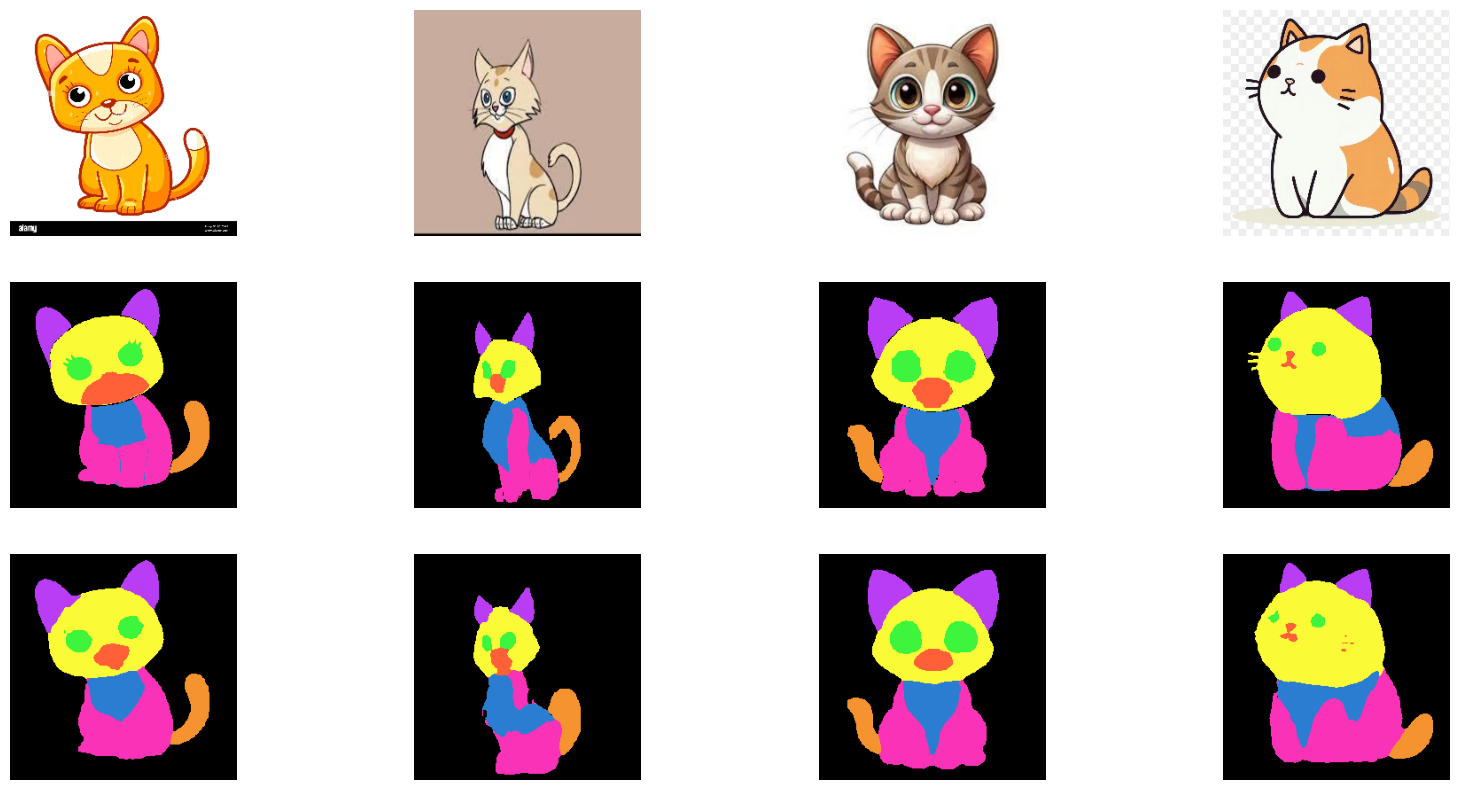

In [20]:
# Define the transformation to be applied to the test images
_, test_transform = img_transform()

#Note: You must train the model before using this param
model_pth = "/kaggle/working/trained_model/best.h5"
num_classes=  len(VOC_CLASSES)
device = "cuda" if torch.cuda.is_available() else "cpu" 

#Show images
pred_show_image_grid(model_pth, device, test_transform, num_classes, num_imgs= 4)

In [23]:
!wget -P /kaggle/working/OneFormer/samples https://thumbs.dreamstime.com/z/illustration-cute-grey-cat-cartoon-isolated-white-background-112004489.jpg

--2024-12-19 19:21:43--  https://thumbs.dreamstime.com/z/illustration-cute-grey-cat-cartoon-isolated-white-background-112004489.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 151.101.193.91, 151.101.129.91, 151.101.1.91, ...
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|151.101.193.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121077 (118K) [image/jpeg]
Saving to: '/kaggle/working/OneFormer/samples/illustration-cute-grey-cat-cartoon-isolated-white-background-112004489.jpg'

illustration-cute-g 100%[===================>] 118.24K  --.-KB/s    in 0.02s   

2024-12-19 19:21:43 (6.68 MB/s) - '/kaggle/working/OneFormer/samples/illustration-cute-grey-cat-cartoon-isolated-white-background-112004489.jpg' saved [121077/121077]



/tmp/ipykernel_36/2145403770.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth, map_location=device)


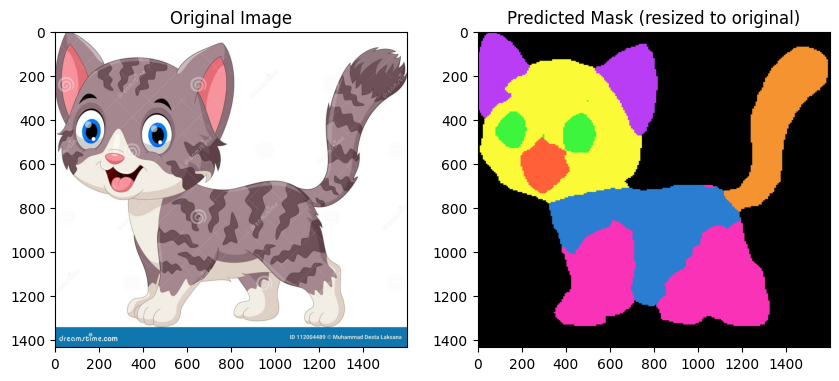

Classes:
0: background
1: cat_body
2: cat_ears
3: cat_eyes
4: cat_face
5: cat_feets
6: cat_muzzle
7: cat_tail


In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Danh sách classes và color map
VOC_CLASSES = [
    "background",
    "cat_body",
    "cat_ears",
    "cat_eyes",
    "cat_face",
    "cat_feets",
    "cat_muzzle",
    "cat_tail",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [42, 125, 209],
    [184, 61, 245],
    [61, 245, 61],
    [250, 250, 55],
    [250, 50, 183],
    [255, 96, 55],
    [245, 147, 49],
]

# Mean và std của ImageNet (thường dùng với ResNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Lớp UnNormalize
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)

unorm = UnNormalize(mean=mean, std=std)

def img_transform():
    test_transform = A.Compose([
        A.Resize(224, 224),   # Resize về 224x224 vì model train ở kích thước này
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    return None, test_transform

_, test_transform = img_transform()

def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img.copy()

    transformed = test_transform(image=img)
    img_tensor = transformed["image"]
    
    return orig_img, img_tensor

def predict_image(model_pth, img_path, device="cpu"):
    # Load mô hình
    checkpoint = torch.load(model_pth, map_location=device)
    num_classes = len(VOC_CLASSES)
    model = smp.DeepLabV3Plus(
        encoder_name="resnext101_32x8d",
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load ảnh
    orig_img, img_tensor = load_image(img_path)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Dự đoán
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask = pred.argmax(dim=1).squeeze(0).cpu().numpy()

    # Gán màu cho pred_mask
    color_pred_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
    for c, color in enumerate(VOC_COLORMAP):
        color_pred_mask[pred_mask == c] = np.array(color, dtype=np.uint8)

    # Resize color_pred_mask về kích thước gốc của ảnh
    orig_height, orig_width = orig_img.shape[:2]
    color_pred_mask_resized = cv2.resize(color_pred_mask, (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

    # Hiển thị ảnh gốc và mask phóng to
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    # Không tắt axis để hiển thị thước đo
    # plt.axis("off") # Bỏ dòng này

    plt.subplot(1,2,2)
    plt.imshow(color_pred_mask_resized)
    plt.title("Predicted Mask (resized to original)")
    # plt.axis("off") # Bỏ dòng này

    plt.show()

    # In thông tin về classes
    print("Classes:")
    for i, cls in enumerate(VOC_CLASSES):
        print(f"{i}: {cls}")

# Ví dụ sử dụng:
model_pth = "/kaggle/working/trained_model/last.h5"
img_path = "/kaggle/working/OneFormer/samples/illustration-cute-grey-cat-cartoon-isolated-white-background-112004489.jpg"
device = "cuda" if torch.cuda.is_available() else "cpu"

predict_image(model_pth, img_path, device=device)
